In [1]:
import os
import math
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import torch
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

In [2]:
plt.style.use([hep.style.ROOT, hep.style.firamath])
plt.rcParams.update({'lines.markersize': 6})
plt.rcParams.update({'errorbar.capsize': 8})
plt.rcParams.update({'lines.linewidth': 2})

In [3]:
from src.models import TranAD, iTransformer

In [4]:
modes = ['local (incl. OR)', 'local (maj. voting)', 'global']

## read results

In [70]:
datasets = ['creditcard_normal', 'GECCO_normal', 'MSL_new', 'SMAP_new', 'SMD', 'SWaT', 'SWaT_1D', 'UCR', 'WADI']
modeltype = 'iTransformer'
reco = True

In [71]:
all_results = {dataset: {} for dataset in datasets}

for dataset in datasets:
    config = {}

    print(f'Loading {dataset}')
    if reco:
        paths = glob.glob(f'{modeltype}_paramsearch_reco_lxplus/{modeltype}_{dataset}/*' )
    else:
        paths = glob.glob(f'{modeltype}_paramsearch_fc_lxplus/{modeltype}_{dataset}/*' )
    paths = sorted(paths)
    print(len(paths)) 
    # print(paths)

    for path in paths:
        key = path.split('/')[2]
        path = glob.glob(f'{path}/rep_*/results/')  # will give all 5 repetitions
        path = sorted(path)
        # print(len(path))

        tmp = pd.DataFrame()
        for i, rep_path in enumerate(path):
            res_path = os.path.join(rep_path, 'res.csv')
            # print(res_path)
            if not os.path.exists(res_path):
                print(f'Skipping {key} rep {i+1}')
                continue
            res = pd.read_csv(res_path).iloc[-3:]
            tmp = pd.concat((tmp, res))
        
        tmp.rename(columns={'Unnamed: 0': 'mode'}, inplace=True)
        mean_values = tmp.groupby('mode').mean()
        std_values = tmp.groupby('mode').std()
        median_values = tmp.groupby('mode').median()
        mean_values = mean_values.reindex(['local_all', 'local_all_maj', 'global'])
        std_values = std_values.reindex(['local_all', 'local_all_maj', 'global'])
        median_values = median_values.reindex(['local_all', 'local_all_maj', 'global'])

        window_value = key.split('_')[0].replace('window', '')
        steps_value = key.split('_')[1].replace('steps', '')
        dmodel_value = key.split('_')[2].replace('dmodel', '')
        feats_value = key.split('_')[3].replace('feats', '')
        eps_value = key.split('_')[4].replace('eps', '')
        config[key] = {'window': window_value, 'steps': steps_value, 'dmodel': dmodel_value, 'feats': feats_value, 'eps': eps_value}
        all_results[dataset][key] = {'mean': mean_values, 'std': std_values, 'median': median_values, 'window': window_value, 'steps': steps_value, 'dmodel': dmodel_value,}

    config = pd.DataFrame(config).T
    config.to_csv(f'studies_paramsearch_reco/configs/{dataset}_config.csv')
    
print(all_results['creditcard_normal']['window10_steps1_dmodel10_feats-1_eps10']['mean'])


Loading creditcard_normal
12
Loading GECCO_normal
12
Loading MSL_new
12
Loading SMAP_new
12
Skipping window15_steps8_dmodel15_feats-1_eps10 rep 4
Loading SMD
12
Loading SWaT
12
Loading SWaT_1D
12
Loading UCR
12
Loading WADI
12
                     f1  precision    recall   TP       TN     FP     FN  \
mode                                                                       
local_all      0.000401   0.000225  0.001852  0.2  84447.4  887.6  107.8   
local_all_maj  0.000000   0.000000  0.000000  0.0  85335.0    0.0  108.0   
global         0.000000   0.000000  0.000000  0.0  85282.0   53.0  108.0   

                ROC/AUC       MCC  threshold  detection level q  Hit@100%  \
mode                                                                        
local_all      0.495725 -0.002995        NaN            0.00001       NaN   
local_all_maj  0.500000  0.000000        NaN            0.00001       NaN   
global         0.499689 -0.000885   0.029427                NaN       1.0   

      

In [74]:
best_config = []

for dataset, results in all_results.items():
    mcc_scores = []
    for key, metrics in results.items():
        mcc_scores.append({
            'dataset': dataset,
            'model': key,
            'local_all': metrics['mean'].loc['local_all', 'MCC'],
            'local_all_maj': metrics['mean'].loc['local_all_maj', 'MCC'],
            'global': metrics['mean'].loc['global', 'MCC'],
            'max_MCC': metrics['mean']['MCC'].max(),
            'max_MCC_mode': metrics['mean']['MCC'].idxmax(),
            'local_all_std': rf"{metrics['mean'].loc['local_all', 'MCC'].round(3)} $\pm$ {metrics['std'].loc['local_all', 'MCC'].round(3)}",
            'local_all_maj_std': rf"{metrics['mean'].loc['local_all_maj', 'MCC'].round(3)} $\pm$ {metrics['std'].loc['local_all_maj', 'MCC'].round(3)}",
            'global_std': rf"{metrics['mean'].loc['global', 'MCC'].round(3)} $\pm$ {metrics['std'].loc['global', 'MCC'].round(3)}",
            'window': metrics['window'],
            'steps': metrics['steps'],
            'dmodel': metrics['dmodel'],
        })
    mcc_df = pd.DataFrame(mcc_scores)
    # print(mcc_df)
    # mcc_df.to_csv(f'studies_paramsearch_reco/data/{dataset}_mcc.csv')

    best_idx = mcc_df['max_MCC'].idxmax()
    # print('idx', best_idx)
    best_config.append({
        'dataset': dataset,
        'model': mcc_df['model'][best_idx],
        'max_MCC': mcc_df['max_MCC'].max(),
        'max_MCC_mode': mcc_df['max_MCC_mode'][best_idx],
        'window': mcc_df['window'][best_idx],
        'steps': mcc_df['steps'][best_idx],
        'dmodel': mcc_df['dmodel'][best_idx],
    })
    
best_config = pd.DataFrame(best_config)
print(best_config)
best_config.to_csv(f'studies_paramsearch_reco/configs/best_config.csv')


             dataset                                      model   max_MCC  \
0  creditcard_normal    window96_steps48_dmodel19_feats-1_eps10  0.248765   
1       GECCO_normal      window12_steps6_dmodel2_feats-1_eps10  0.773240   
2            MSL_new  window250_steps25_dmodel250_feats-1_eps10  0.946398   
3           SMAP_new     window15_steps2_dmodel15_feats-1_eps10  0.826243   
4                SMD   window350_steps35_dmodel70_feats-1_eps10  0.966574   
5               SWaT    window51_steps26_dmodel10_feats-1_eps10  0.968980   
6            SWaT_1D     window10_steps5_dmodel10_feats-1_eps10  0.808932   
7                UCR  window100_steps10_dmodel100_feats-1_eps10  0.789549   
8               WADI    window96_steps10_dmodel96_feats30_eps10  0.848359   

    max_MCC_mode window steps dmodel  
0      local_all     96    48     19  
1      local_all     12     6      2  
2  local_all_maj    250    25    250  
3  local_all_maj     15     2     15  
4      local_all    350    35     

In [85]:
def plot_scores_mean_std_err2(results, modes, dataset, models, metric='MCC', name=None, labels=None):
    if labels is None:
        labels = [f"W: {results[dataset][model]['window']}, S: {results[dataset][model]['steps']}, M: {results[dataset][model]['dmodel']}" for model in models]

    fig = plt.figure(figsize=(25, 7))
    colors = plt.cm.plasma(np.linspace(0, 1, len(models)+1))
    markers = ['o', 's', 'D']  # Different markers for different modes
    plt.rcParams.update({'lines.markersize': 8})

    width_modes = 0.015  # the width of the bars
    width_models = 0.025
    x = np.arange(1)  # the label locations

    for j, model in enumerate(models):
        for i, mode in enumerate(modes):
            # print(f'{model} {mode} {dataset}')
            scores = {'mean': np.empty(0), 'std': np.empty(0)}
            for val in ['mean', 'std']:
                if model in results[dataset].keys():
                    scores[val] = np.append(scores[val], results[dataset][model][val][metric].iloc[i])
                else:
                    scores[val] = np.append(scores[val], 0)

            x_positions = x + j * len(modes) * width_models + i * width_modes  # add different offset for each model and mode
            plt.errorbar(x_positions, scores['mean'], yerr=scores['std'], fmt=markers[i], label=f'{labels[j]} ({mode})', color=colors[j])

    plt.xticks(ticks=[(len(models) * len(modes) * width_models) / 2], labels=[dataset])
    plt.grid('gray', axis='y')
    if metric == 'MCC':
        plt.ylim(-0.2, 1.05)
    else:
        plt.ylim(top=1.0)
    if metric == 'ROC/AUC':
        plt.ylabel('ROC AUC')
    elif metric == 'f1':
        plt.ylabel('F1')
    else:
        plt.ylabel(metric)

    # Create legend handles for colors
    color_handles = [
        mpatches.Patch(color=colors[i], label=labels[i]) for i, model in enumerate(models)
    ]

    # Create legend handles for marker shapes
    shape_handles = [
        mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label=modes[0]),
        mlines.Line2D([], [], color='black', marker='s', linestyle='None', markersize=10, label=modes[1]),
        mlines.Line2D([], [], color='black', marker='D', linestyle='None', markersize=10, label=modes[2]),
    ]

    # Add separate legends to the plot
    if dataset in ['MSL_new', 'SMAP_new', 'SWaT', 'SWaT_1D', 'WADI']:
        legend2 = plt.legend(handles=shape_handles, title='Anomaly labels', bbox_to_anchor=(0.8, 0.4), loc='upper left') 
    elif dataset in ['SMD']:
        legend2 = plt.legend(handles=shape_handles, title='Anomaly labels', bbox_to_anchor=(0.8, 0.65), loc='upper left')
    else:
        legend2 = plt.legend(handles=shape_handles, title='Anomaly labels', bbox_to_anchor=(0.8, 1.0), loc='upper left')  
    plt.gca().add_artist(legend2)  # Add the first legend manually to the axes
    legend1 = plt.legend(handles=color_handles, title='Models', bbox_to_anchor=(1, 1.05), loc='upper left')
    # plt.gca().add_artist(legend1)  # Add the first legend manually to the axes
    
    plt.tight_layout()
    if name:
        if metric == 'ROC/AUC':
            metric = 'rocauc'
        plt.savefig(f'./studies_paramsearch_reco/{dataset}_{metric}_{name}.png', facecolor='w')
    plt.show()


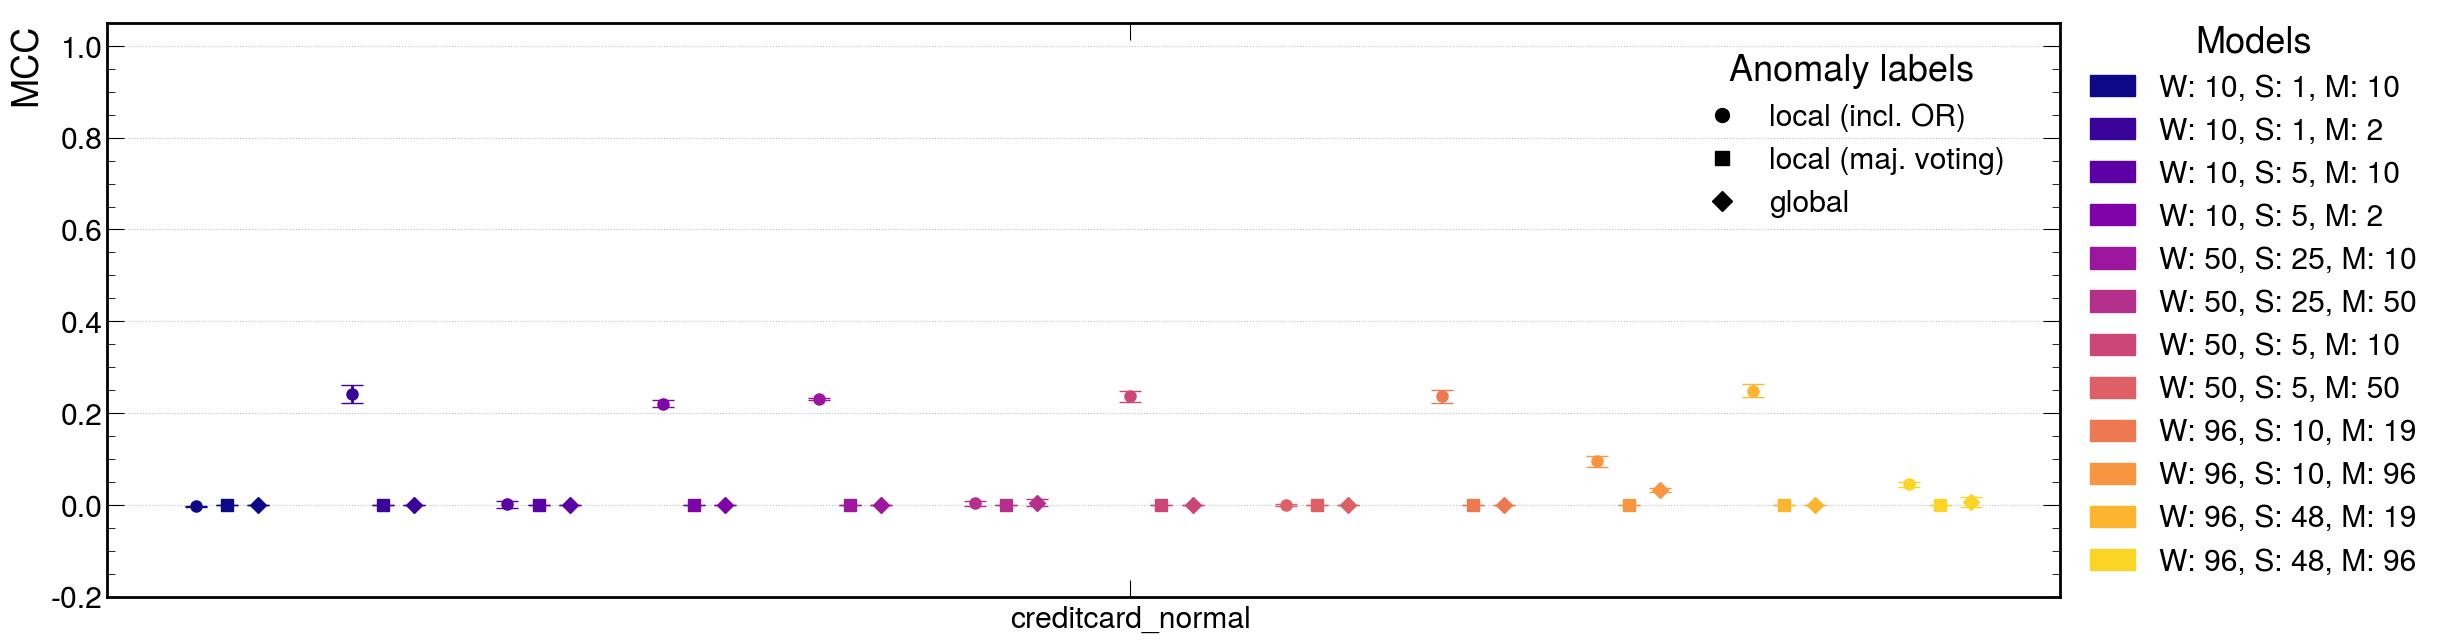

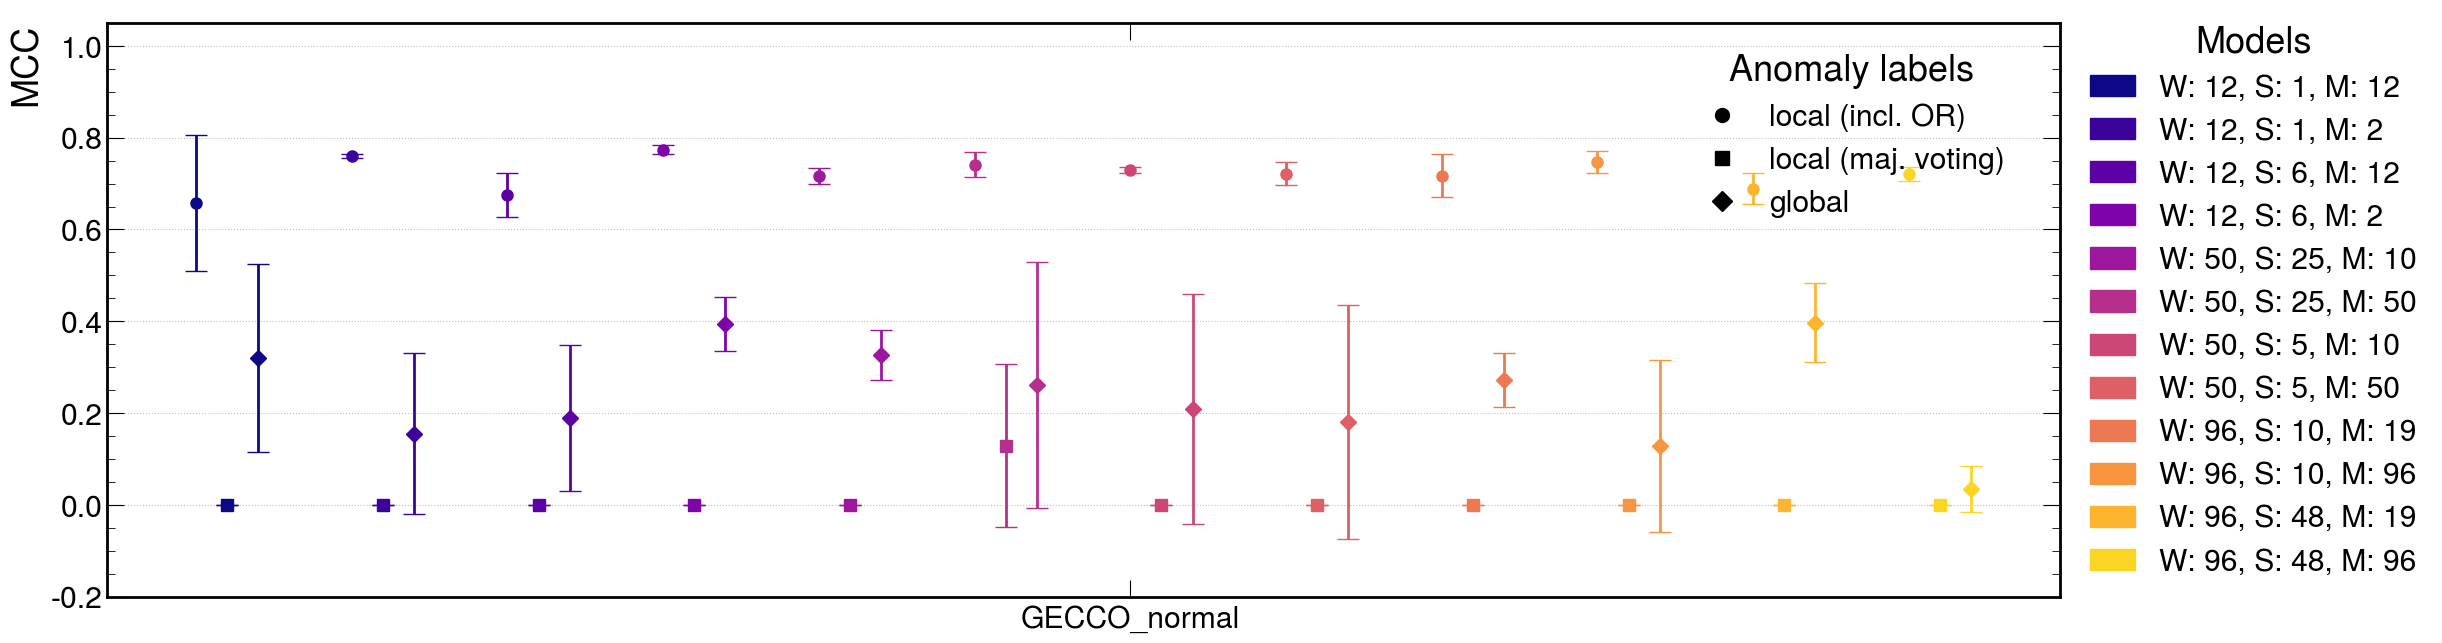

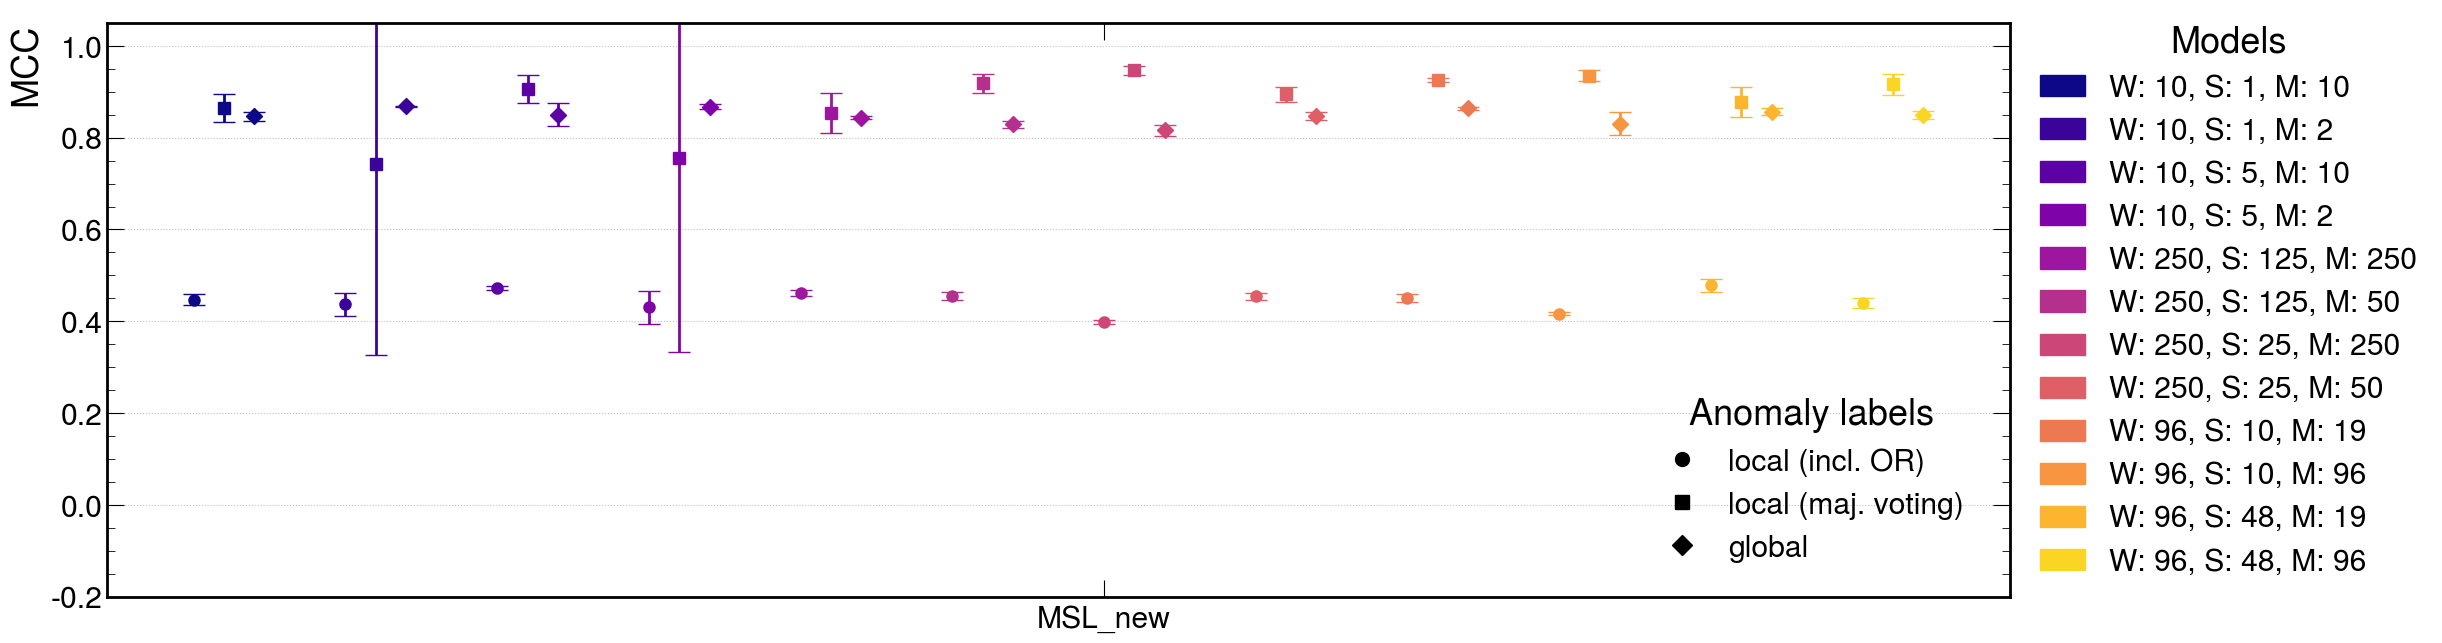

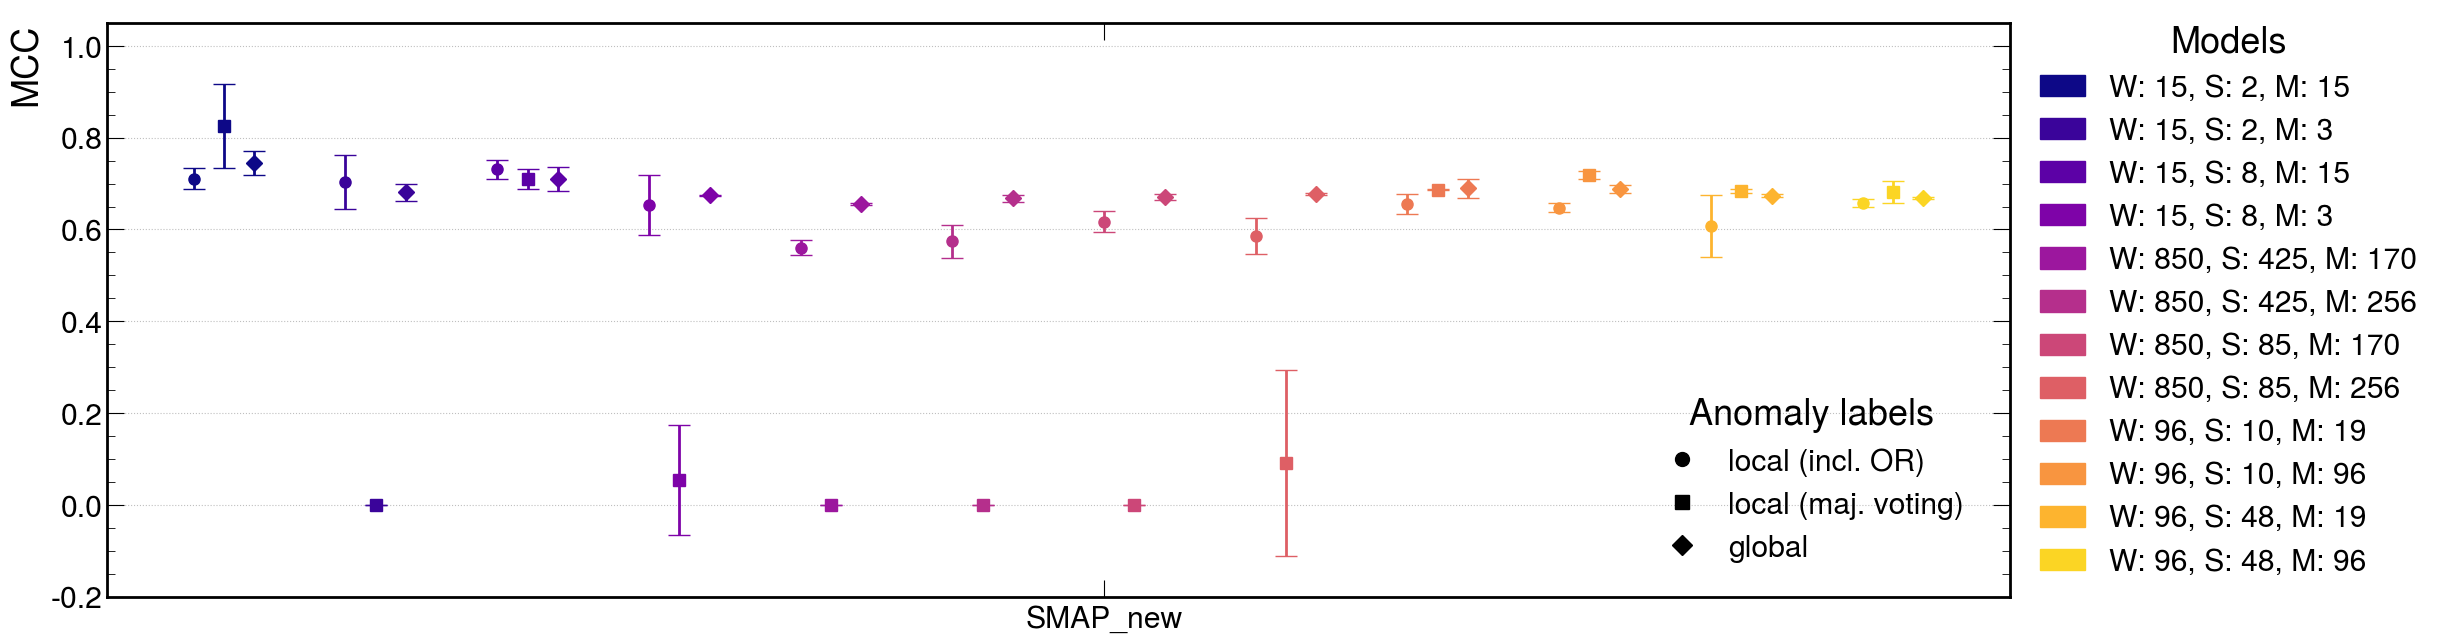

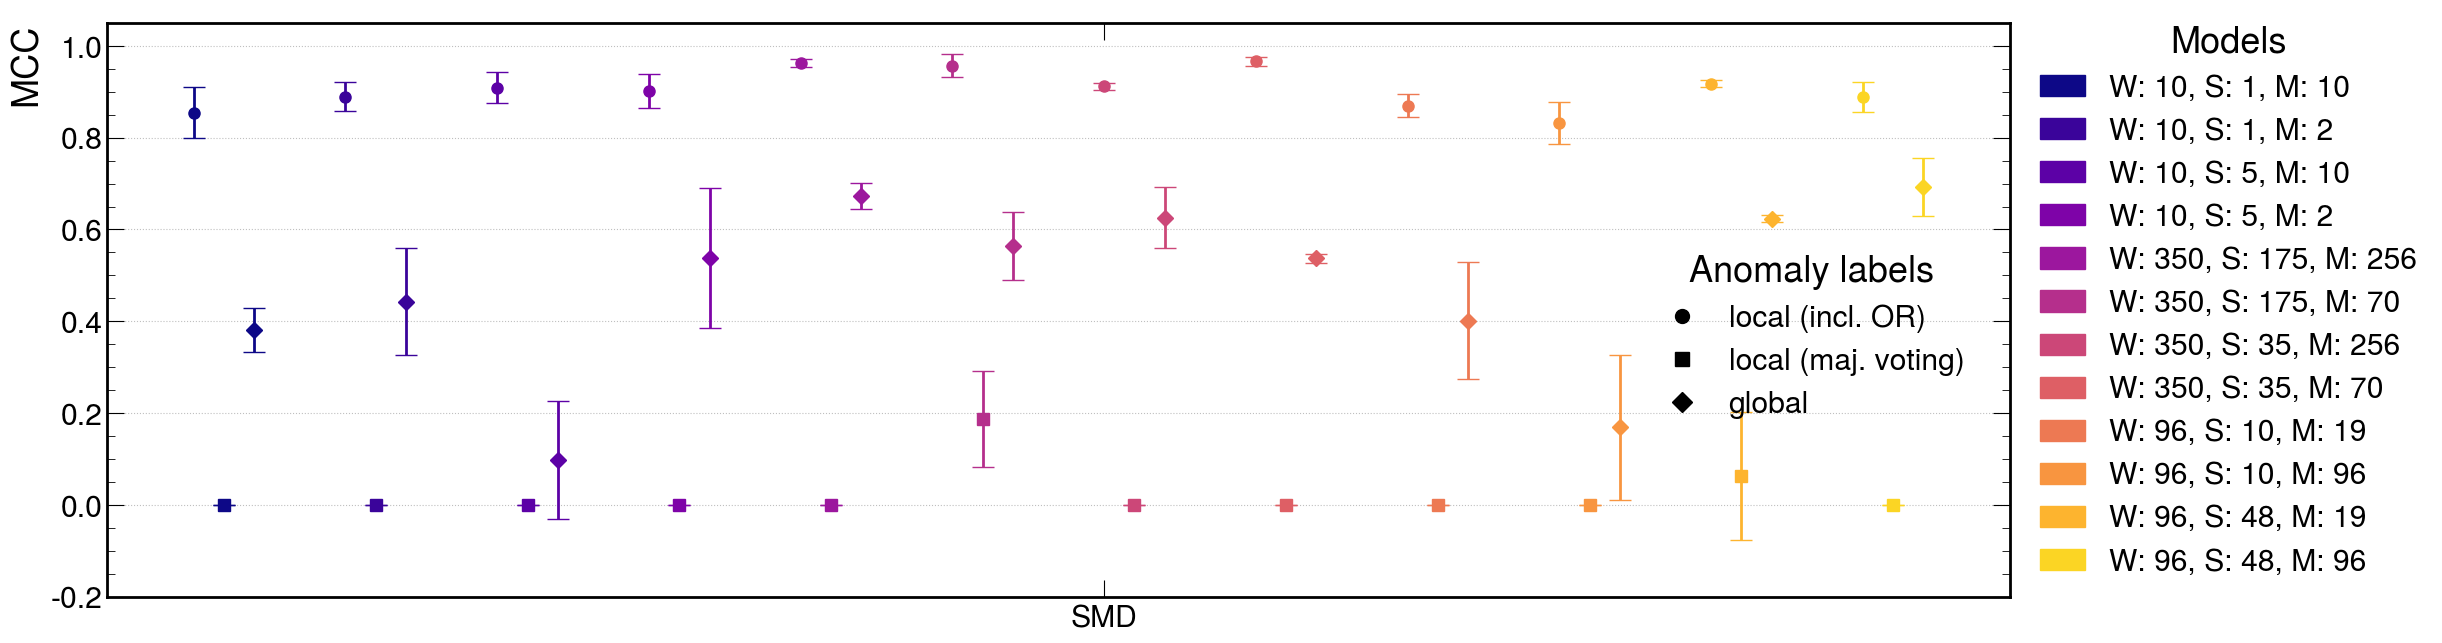

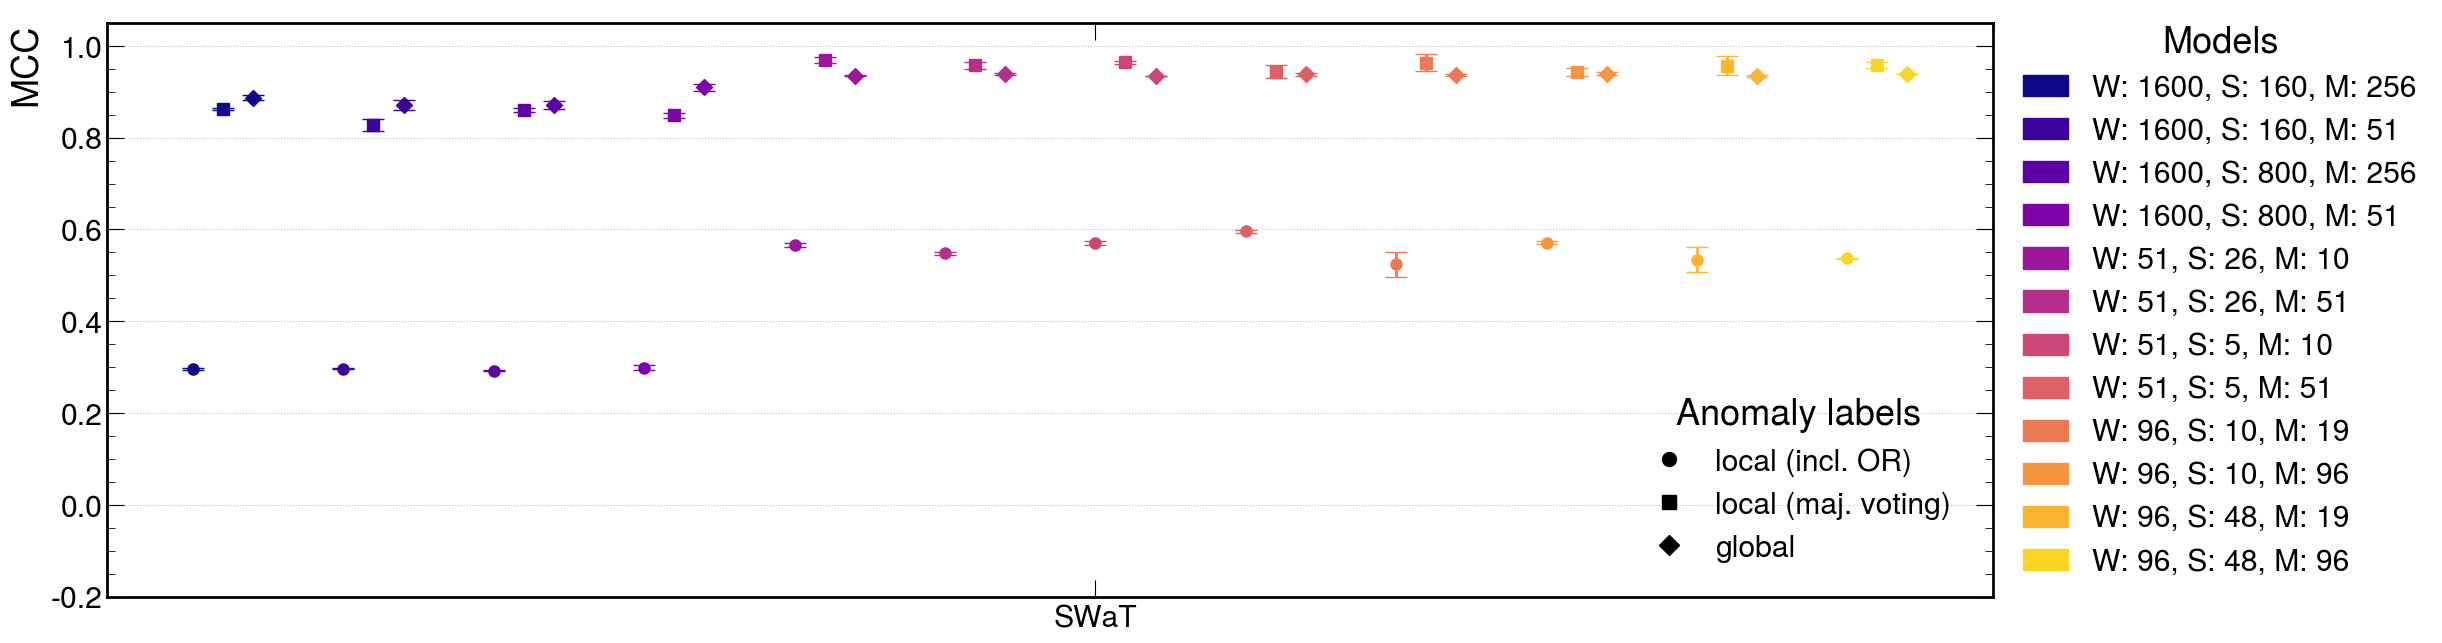

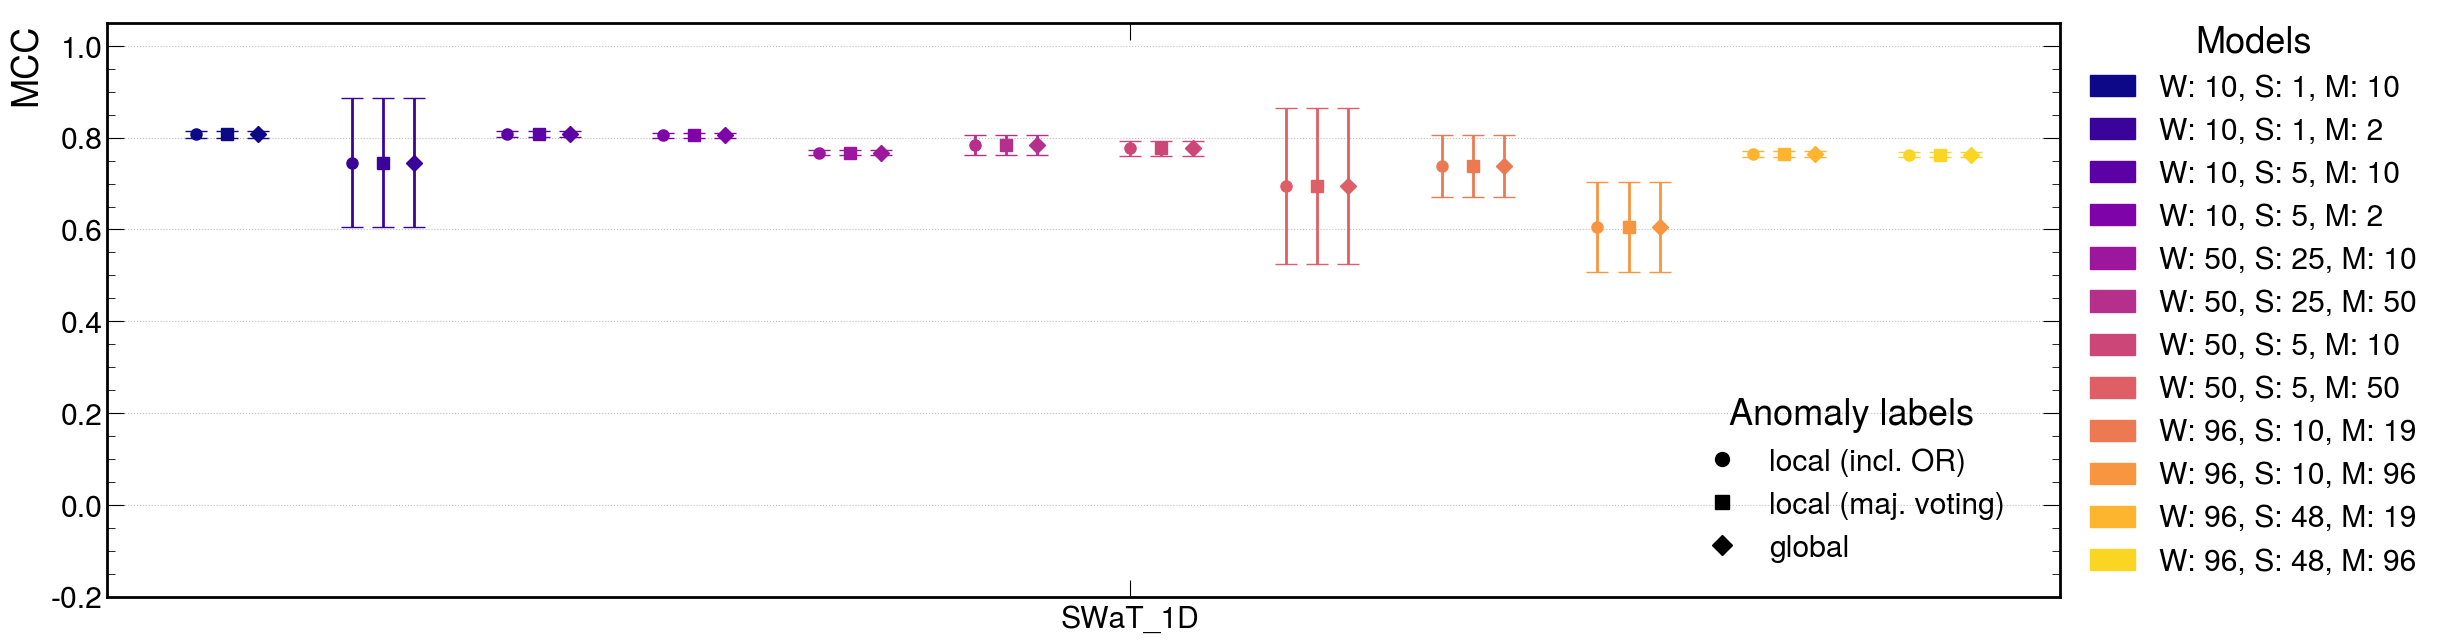

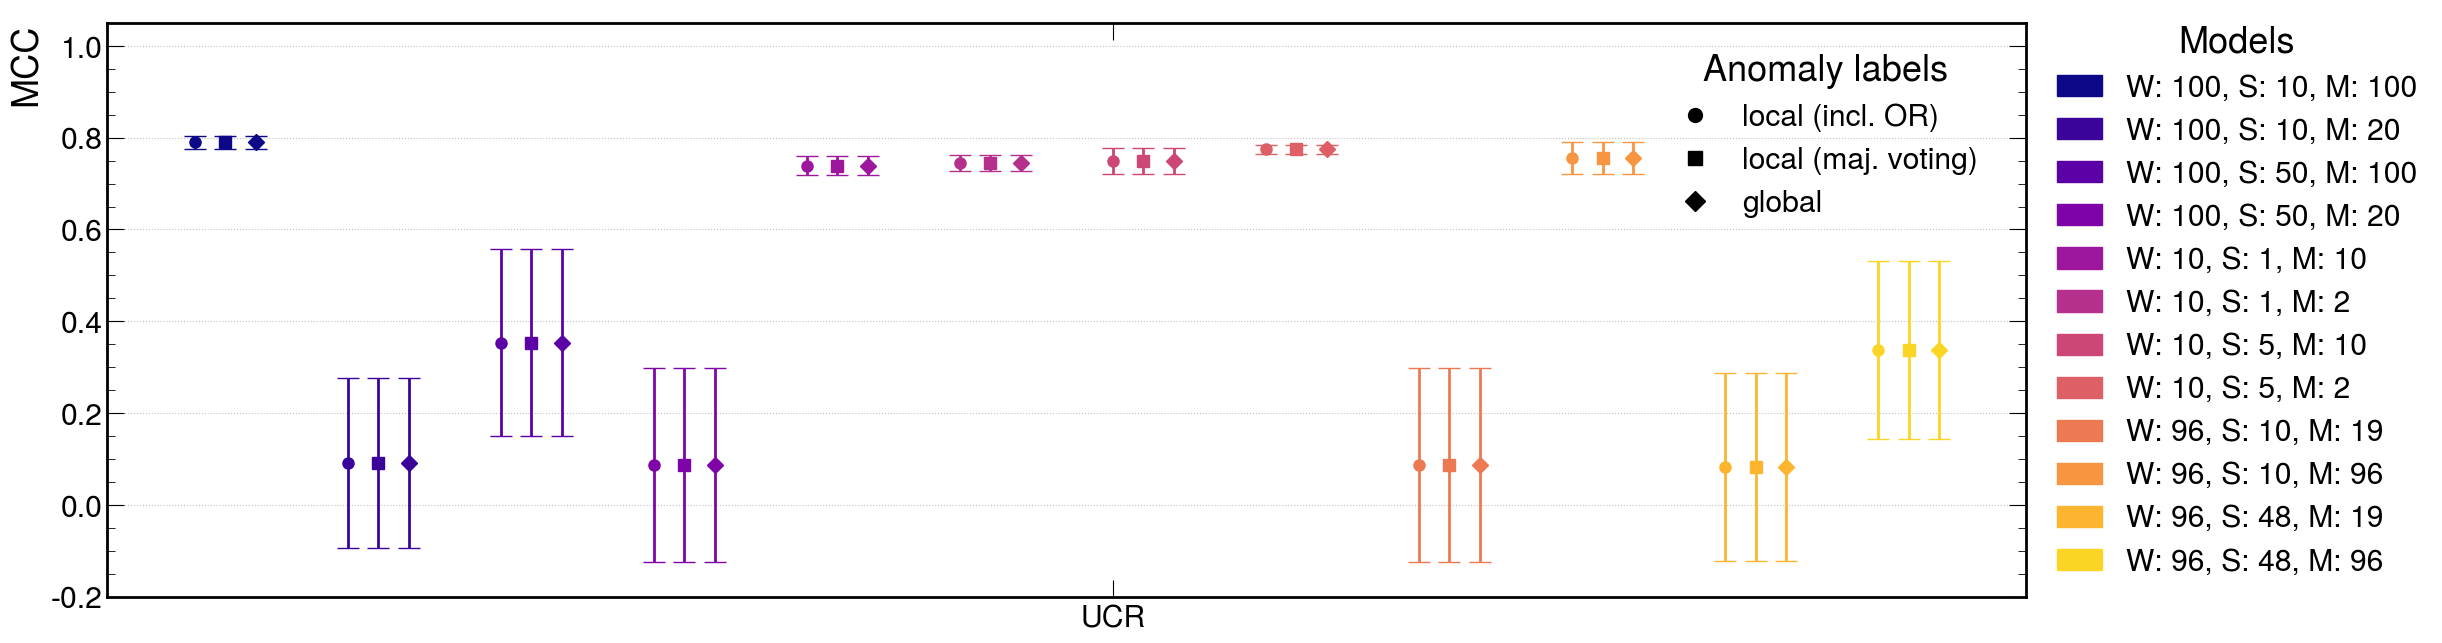

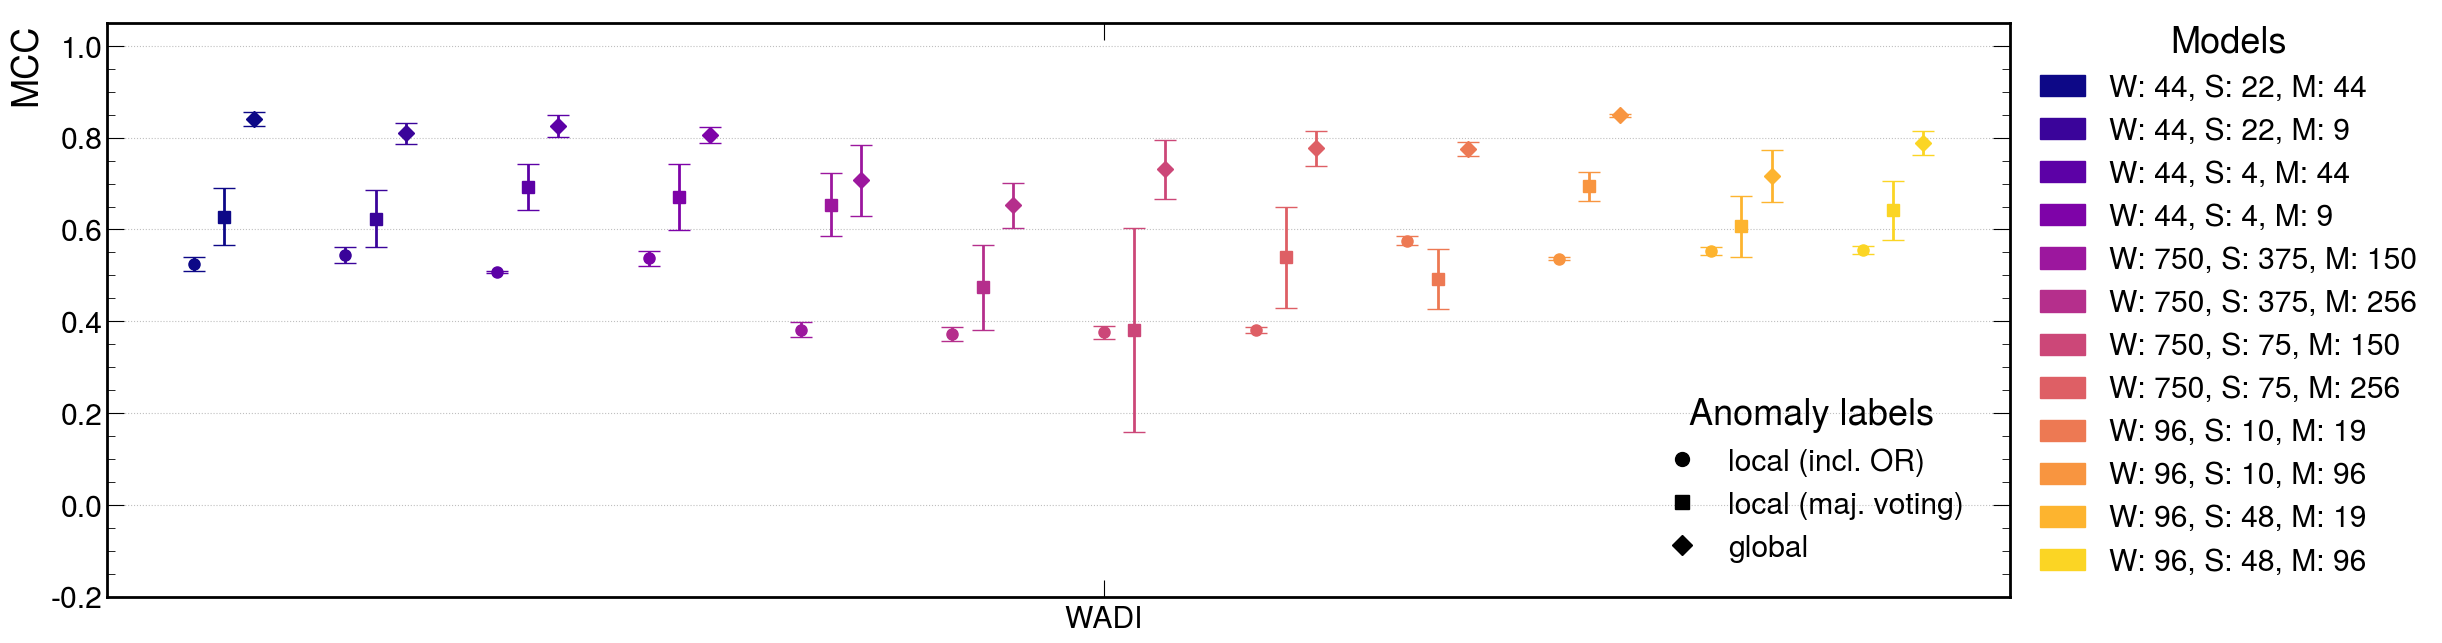

In [ ]:
data_plot = datasets  # ['creditcard_normal', 'GECCO_normal', 'MSL_new', 'SMAP_new', 'SWaT_1D', 'UCR']

for dataset in data_plot:
    models_plot = sorted(list(all_results[dataset].keys()))
    labels = [l[:-14] for l in models_plot]
    labels = [l.replace('_', ' ') for l in labels]
    # name = 'reco2'
    name = None
    plot_scores_mean_std_err2(all_results, modes, dataset, models_plot, metric='MCC', name=name, labels=None)
